<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_projects/blob/main/Sylwia_Zemsta_Projekt_GU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Zbiór danych Stanford Dogs 

Zbiór danych Stanford Dogs zawiera obrazy 120 ras psów z całego świata. Ten zbiór danych został utworzony przy użyciu obrazów i adnotacji z ImageNet w celu szczegółowej kategoryzacji obrazów. Istnieje 20 580 obrazów, z których 12 000 jest używanych do szkolenia, a 8580 do testów. Etykiety klas i adnotacje z obwiednią są dostępne dla wszystkich 12 000 obrazów.

## Link do zbioru danych
http://vision.stanford.edu/aditya86/ImageNetDogs/main.html


## Dane w projekcie
W moim projekcie klasyfikuje obrazki 7 ras psów. Łącznie używam 1150 obrazków do szkolenia i 128 do testów.

In [ ]:
#biblioteki
import re
import random
import numpy as np
import requests
import keras as k
from io import BytesIO
from PIL import Image, ImageFile
from os import path, getcwd, listdir, environ
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras import Model, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import InceptionV3

%matplotlib inline

In [ ]:
#wczytywanie obrazków
def read_img(file_loc):
    img = Image.open(file_loc)
    return img

In [ ]:
#rysowanie przykładowych obrazków
def print_random_images():
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    title = ""
    
    for i in range(1, columns * rows +1):
        cat = random.choice(breeds)
        dir_path = path.join(data_dir, cat)
        loc = path.join(dir_path, random.choice(listdir(dir_path)))
        img = read_img(loc)
        title = re.search(r'\-(.*)', cat)
            
        axes = fig.add_subplot(rows, columns, i, title=title.group(0))
        fig.tight_layout(pad=1.0)
        axes.axis('off')
        title = ""
    
        plt.imshow(img)
        
    plt.show()

In [ ]:
#łączenie z dyskiem Google
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#ścieżka do folderów w którym znajduja sie zdjęcia
data_dir = './gdrive/My Drive/images/Images/Choose/'

breeds = listdir(data_dir) # nazwy plików dla wszystkich ras

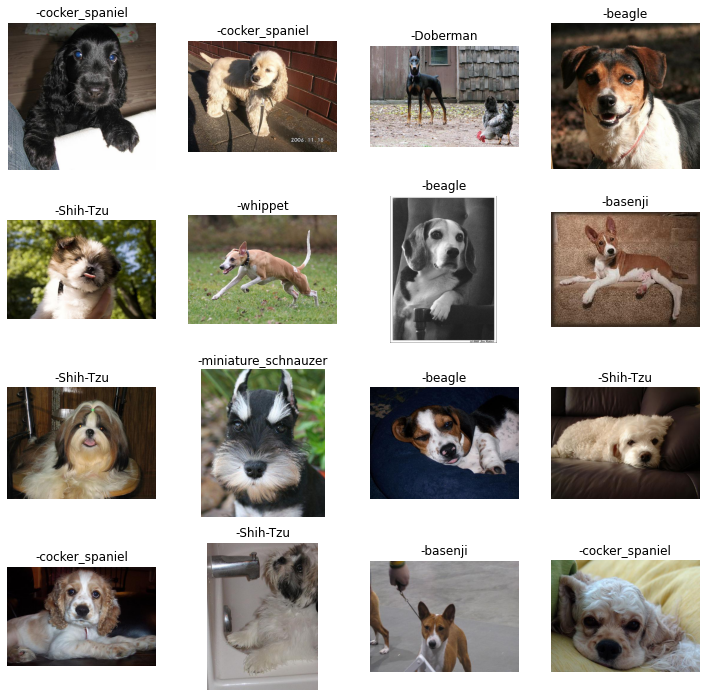

In [ ]:
print_random_images() #przykładowe zdjęcia z zbioru danych

In [ ]:
#etykiety
path=data_dir
dogs_labels = set()
    
for d in breeds:
    dogs_labels.add(d)

In [ ]:
list(dogs_labels) #lsita etykiet

['n02088364-beagle',
 'n02097047-miniature_schnauzer',
 'n02107142-Doberman',
 'n02091134-whippet',
 'n02102318-cocker_spaniel',
 'n02086240-Shih-Tzu',
 'n02110806-basenji']

In [ ]:
dogs_labels = list(dogs_labels)
dogs_labels_path = [path + s for s in dogs_labels] #ścieżki do etykiet

In [ ]:
dogs_labels_path

['./gdrive/My Drive/images/Images/Choose/n02088364-beagle',
 './gdrive/My Drive/images/Images/Choose/n02097047-miniature_schnauzer',
 './gdrive/My Drive/images/Images/Choose/n02107142-Doberman',
 './gdrive/My Drive/images/Images/Choose/n02091134-whippet',
 './gdrive/My Drive/images/Images/Choose/n02102318-cocker_spaniel',
 './gdrive/My Drive/images/Images/Choose/n02086240-Shih-Tzu',
 './gdrive/My Drive/images/Images/Choose/n02110806-basenji']

In [ ]:
import cv2
#załadowanie i zmiana rozmiaru obrazków
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (70,70))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
#tworzenie tablic obrazów i etykiet
X = []
y = []

for type_path, label in zip(dogs_labels_path,dogs_labels) :
    for image_path in listdir(type_path):
        image = load_and_preprocess_image(type_path+"/"+image_path)
        
        X.append(image)
        y.append(label)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

In [ ]:
import numpy as np
import tensorflow as tf
# zamiana etykiet z wektorów na liczby
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i)
    return right_labels

wrong_labels = y
right_labels =np.array(change_to_right(wrong_labels))

In [ ]:
yy=right_labels

In [ ]:
#podział danych
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,yy,test_size=0.1)

In [ ]:
#rozmiar danych
print(X_train.shape)
print(X_test.shape)

(1150, 70, 70, 3)
(128, 70, 70, 3)


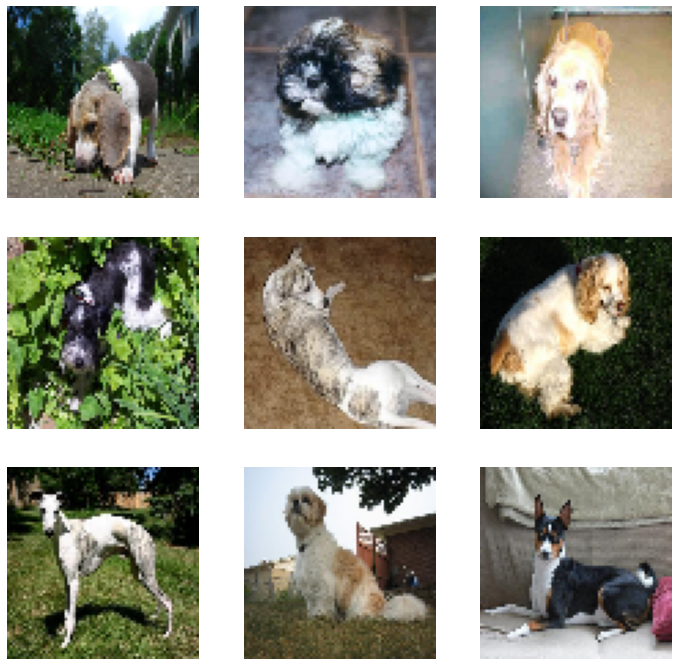

In [ ]:
# save x_test images
xx_test = X_test
yy_test = y_test
#rysuje obrazki poz zmianie rozmiaru
fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

In [ ]:
# augumentacja

rotation_range=30
shift_range=0.30

datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
      )  

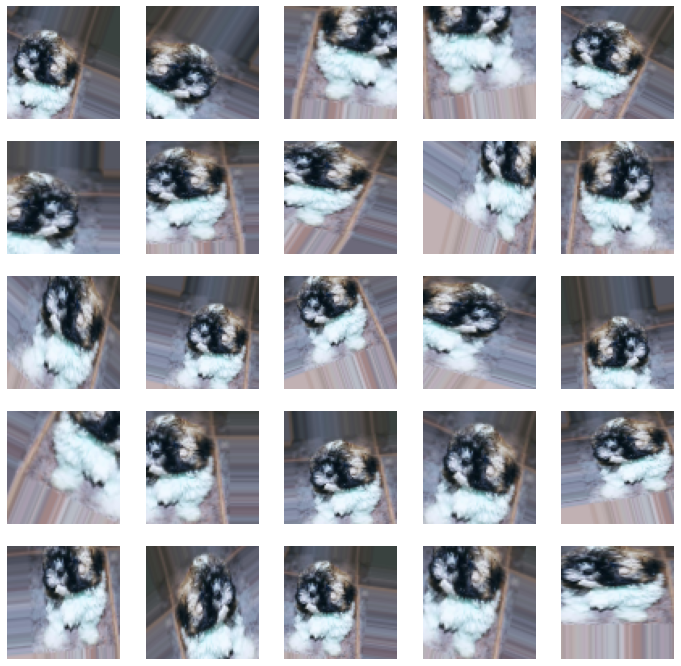

In [ ]:
# przykład augumentacji na jednym obrazku
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(X_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()

In [ ]:
#convert integers to float; normalise and center the mean
x_train=X_train.astype("float32")  
x_test=X_test.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)
x_test=(X_test-mean)/std
x_train=(X_train-mean)/std

import keras as k
N_CLASSES = 7
# labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
#stworzenie sieci konwolucyjnej
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.3
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation='relu', kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))


  model2.add(Flatten())
  model2.add(Dense(512, activation='relu',kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2


In [ ]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=70, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

In [ ]:
# szacowanie modelu z k-fold i cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

In [ ]:
def objective(trial):
  
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  num_filters =trial.suggest_uniform('num_filters', .00,50)
  
  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


  #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

  return np.mean(scores)

In [ ]:
# OPTUNA

! pip install optuna
import optuna

     |████████████████████████████████| 286kB 8.9MB/s 
     |████████████████████████████████| 1.1MB 34.0MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 481kB 49.0MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 133kB 57.9MB/s 
     |████████████████████████████████| 112kB 61.9MB/s 
  Created wheel for alembic: filename=alembic-1.5.3-py2.py3-none-any.whl size=155547 sha256=fb28d0c905a3d22ce7d54a58cc12a077148fb9b5b879ebd350cb9339c8d5e756
  Stored in directory: /root/.cache/pip/wheels/7f/ed/1b/a66a0cbca75fd3e374bd5cc60c443e5675f10ef1f1f78ec31d
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=374584ff7224032288e31dc0fd79fd321f88a4d866fff40bbffc8e32e0fe3155
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sh

In [ ]:
img_rows, img_cols , channels= 70,70,3
#Optymalizacja
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=10)

[I 2021-01-30 21:34:53,092] A new study created in memory with name: no-name-e77d8121-d74d-41eb-bb20-8b5b6550f5de


> 37.826
> 43.043
> 37.391
> 47.391


[I 2021-01-30 21:41:35,632] Trial 0 finished with value: 0.40695652961730955 and parameters: {'rotation_range': 28.996758972046216, 'shift_range': 0.0307415687471045, 'num_filters': 27.65464896970076}. Best is trial 0 with value: 0.40695652961730955.


> 37.826
> 38.696
> 40.870
> 44.783
> 40.000


[I 2021-01-30 21:48:57,672] Trial 1 finished with value: 0.4017391264438629 and parameters: {'rotation_range': 22.293556595396815, 'shift_range': 0.17876021492731664, 'num_filters': 41.83884774046467}. Best is trial 0 with value: 0.40695652961730955.


> 36.522
> 43.478
> 44.348
> 44.783
> 49.130


[I 2021-01-30 21:55:41,879] Trial 2 finished with value: 0.4539130389690399 and parameters: {'rotation_range': 4.474652274185101, 'shift_range': 0.08883018592447234, 'num_filters': 31.28784435427243}. Best is trial 2 with value: 0.4539130389690399.


> 45.217
> 37.826
> 33.478
> 42.609
> 45.217


[I 2021-01-30 22:02:10,640] Trial 3 finished with value: 0.386956524848938 and parameters: {'rotation_range': 13.277752393619304, 'shift_range': 0.18151900841229673, 'num_filters': 12.399102934979117}. Best is trial 2 with value: 0.4539130389690399.


> 34.348
> 37.826
> 34.783
> 33.913
> 43.043


[I 2021-01-30 22:08:41,095] Trial 4 finished with value: 0.3713043510913849 and parameters: {'rotation_range': 28.60272603554801, 'shift_range': 0.12504458669069252, 'num_filters': 11.315846069891316}. Best is trial 2 with value: 0.4539130389690399.


> 36.087
> 39.565
> 42.174
> 32.174
> 44.348


[I 2021-01-30 22:16:12,266] Trial 5 finished with value: 0.395652174949646 and parameters: {'rotation_range': 8.168446902584522, 'shift_range': 0.07392188251339775, 'num_filters': 46.725160328708526}. Best is trial 2 with value: 0.4539130389690399.


> 39.565
> 40.870
> 36.957
> 42.174
> 47.826


[I 2021-01-30 22:22:48,968] Trial 6 finished with value: 0.4060869574546814 and parameters: {'rotation_range': 9.77778444157395, 'shift_range': 0.06541488071140915, 'num_filters': 24.577999154664266}. Best is trial 2 with value: 0.4539130389690399.


> 35.217
> 38.261
> 37.391
> 36.522
> 47.826


[I 2021-01-30 22:29:31,452] Trial 7 finished with value: 0.4052173912525177 and parameters: {'rotation_range': 28.448639633842966, 'shift_range': 0.1269345905997807, 'num_filters': 26.33447106577831}. Best is trial 2 with value: 0.4539130389690399.


> 42.609
> 34.783
> 33.043
> 33.478
> 34.348


[I 2021-01-30 22:35:47,430] Trial 8 finished with value: 0.33217390775680544 and parameters: {'rotation_range': 27.66945940716768, 'shift_range': 0.021408201195809374, 'num_filters': 5.619566717209046}. Best is trial 2 with value: 0.4539130389690399.


> 30.435
> 37.826
> 40.870
> 44.783
> 46.957


[I 2021-01-30 22:43:02,037] Trial 9 finished with value: 0.4208695650100708 and parameters: {'rotation_range': 14.435299473673892, 'shift_range': 0.09110422417359368, 'num_filters': 37.943103257713325}. Best is trial 2 with value: 0.4539130389690399.


> 40.000


In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 10
Best trial:
  Value: 0.4539130389690399
  Params: 
    rotation_range: 4.474652274185101
    shift_range: 0.08883018592447234
    num_filters: 31.28784435427243


In [ ]:
#uczenie z zoptymalizowanymi parametrami
num_filters =trial.params.get('num_filters') 
rotation_range=trial.params.get('rotation_range')
shift_range=trial.params.get('shift_range')
  
datagen = ImageDataGenerator( 
    rotation_range=rotation_range,
    width_shift_range=shift_range,
    height_shift_range=shift_range,
    zoom_range=shift_range
    )

datagen.fit(x_train)

#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen)

> 34.783
> 37.391
> 35.217
> 43.043
> 34.783


In [ ]:
#Wykresy
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



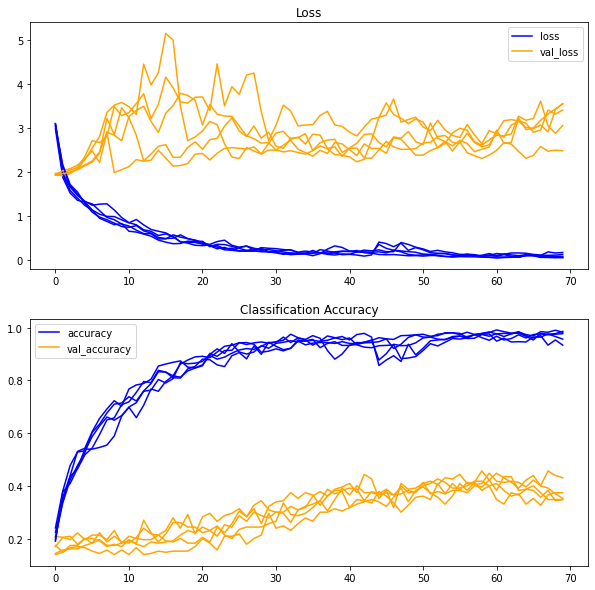

Accuracy: mean=37.043 std=3.152, n=5


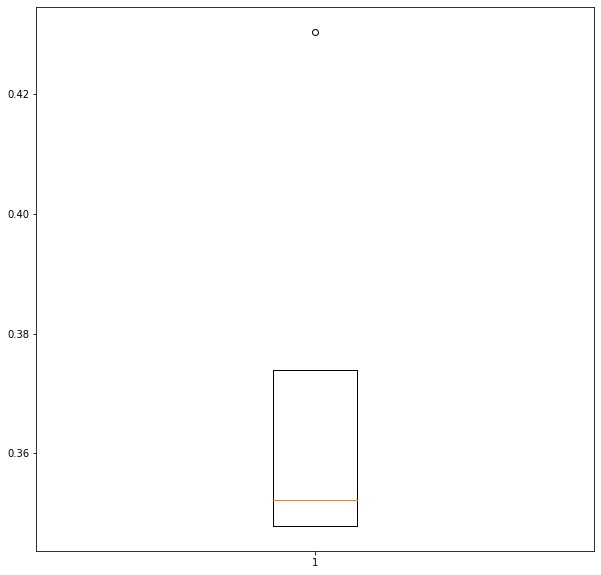

Scores:  [0.3478260934352875, 0.373913049697876, 0.35217392444610596, 0.43043479323387146, 0.3478260934352875]


In [ ]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

In [ ]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  40.625 %


In [ ]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix

#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)

[[ 5  3  3  1  2  2  2]
 [ 1  7  1  0  0  0 12]
 [ 4  0  7  2  0  0  4]
 [ 6  0  4  4  1  3  5]
 [ 1  1  0  2  1  0  3]
 [ 1  1  0  0  0 12  4]
 [ 2  4  1  0  0  0 16]]


In [ ]:
predictions = models[0].predict(x_test) 

In [ ]:
label_predictions = encoder.inverse_transform(predictions)

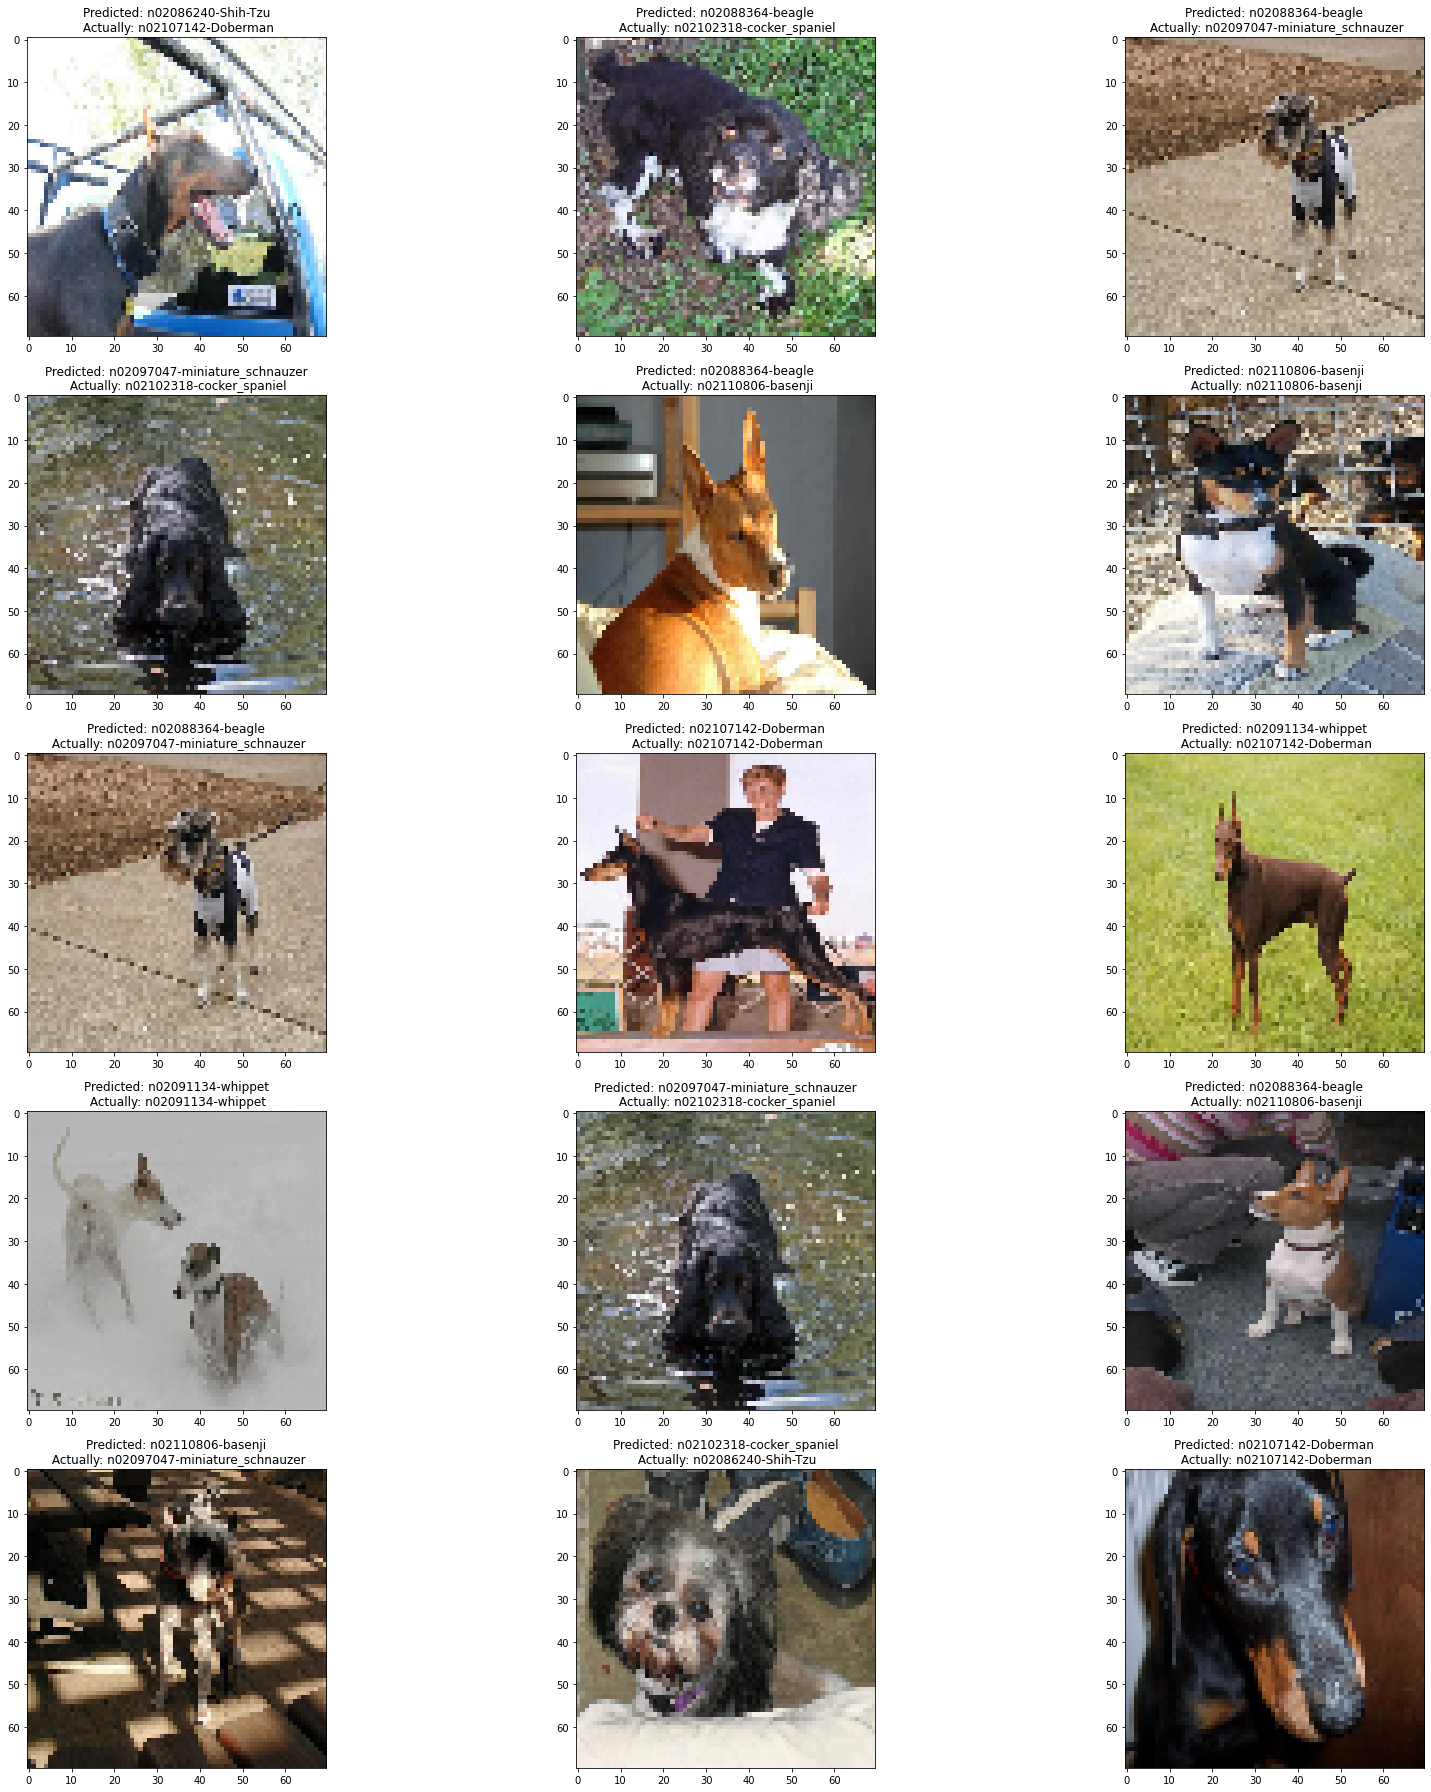

In [ ]:
# obrazki przewidywane a prawdziwe
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()

# MobileNet Architecture

In [ ]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm

from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler


In [ ]:
from keras.applications.mobilenet import MobileNet
imgsize=70

In [ ]:
base_model=MobileNet(include_top=False,alpha=1.0,weights='imagenet',input_shape=(imgsize,imgsize,3))


17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(7,activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 35, 35, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 35, 35, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 35, 35, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 35, 35, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 35, 35, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 35, 35, 32)        0     

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
datagen=ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
    )

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [ ]:
datagen.fit(X_train)

In [ ]:
history=model.fit(datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=len(X_train) / 32, epochs=50,callbacks=callbacks)

Epoch 1/50
35/35 [==============================] - 10s 46ms/step - loss: 2.5775 - accuracy: 0.3043
Epoch 2/50
35/35 [==============================] - 1s 40ms/step - loss: 1.2390 - accuracy: 0.5187
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 1.0317 - accuracy: 0.6381
Epoch 4/50
35/35 [==============================] - 1s 41ms/step - loss: 0.9278 - accuracy: 0.6510
Epoch 5/50
35/35 [==============================] - 1s 41ms/step - loss: 0.8769 - accuracy: 0.6948
Epoch 6/50
35/35 [==============================] - 1s 41ms/step - loss: 0.8818 - accuracy: 0.6884
Epoch 7/50
35/35 [==============================] - 1s 40ms/step - loss: 0.7870 - accuracy: 0.7173
Epoch 8/50
35/35 [==============================] - 1s 41ms/step - loss: 0.7383 - accuracy: 0.7336
Epoch 9/50
35/35 [==============================] - 1s 40ms/step - loss: 0.7506 - accuracy: 0.7333
Epoch 10/50
35/35 [==============================] - 1s 41ms/step - loss: 0.6921 - accuracy: 0.7781
Epoch 11

In [ ]:
score_1 = model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 10ms/step - loss: 1.7040 - accuracy: 0.6250
